In [72]:
# Below are our imports for the spectrogram creation task
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import random
from IPython.display import Audio
from tqdm import tqdm

# ML imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Pytorch imports
import torch
import torch.nn as nn
import torchvision

In [20]:
# pylint: disable=undefined-variable
# Since we have multiple actors in our dataset, we would like to create a pandas dataframe to tag emotion to each audio file
ravdess_path = '../dataset/archive/'
ravdess_dir = os.listdir(ravdess_path)
file_emotion = [] # This will be a list of tuples (emotion, file)

# int to emotion mapping
lookup_table = {
    1 : 'neutral',
    2 : 'calm',
    3 : 'happy',
    4 : 'sad',
    5 : 'angry',
    6 : 'fearful',
    7 : 'disgust',
    8 : 'surprised'
}

for actor_dir in ravdess_dir:
    # ignore . files, happens on mac
    if actor_dir[0] == '.':
        continue
    for file in os.listdir(ravdess_path + actor_dir):
        emotion = lookup_table[int(file.split('-')[2])] # Get the emotion from the file name
        file_emotion.append((emotion, actor_dir + "/" + file))

emotion_tag_df = pd.DataFrame(file_emotion, columns=['emotion', 'file_path'], index=None)

# emotion_tag_df.head()
emotion_tag_df.count()

# export to csv
# emotion_tag_df.to_csv('../dataset/emotion_tag.csv', index=False)


emotion      1440
file_path    1440
dtype: int64

## Visualizing Data

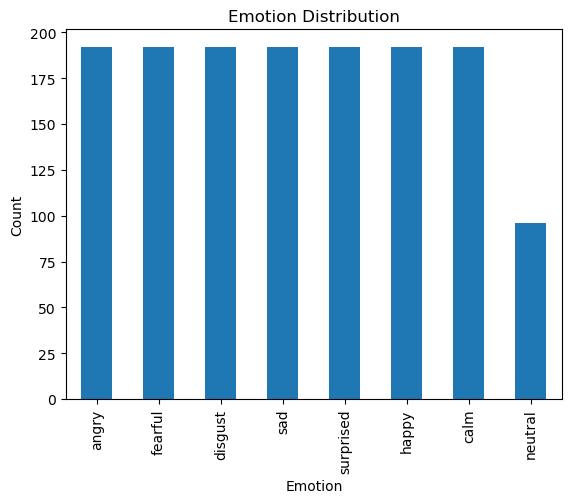

In [21]:
# let us plot the emotion distribution
plt.title('Emotion Distribution')
plt.xlabel('Emotion', )
plt.ylabel('Count')
# plot x axis as emotion and y axis as count
emotion_tag_df['emotion'].value_counts().plot(kind='bar')

plt.show()

In [22]:
# functions to generate mel spectrogram and wave plot
def generate_wave_plot(data, sample_rate, emotion):
    '''
    Function that creates an amplitude vs time plot
    input: data, sample_rate, emotion
    returns: None
    '''
    plt.figure(figsize=(12, 4))
    plt.title("Waveplot for " + emotion)
    librosa.display.waveshow(data, sr=sample_rate)
    plt.show()

def generate_mel_spectrogram(data, sample_rate, emotion):
    '''
    Function that creates a mel spectrogram
    input: data, sample_rate, emotion
    returns: None
    '''
    plt.figure(figsize=(12, 4))
    plt.title("Mel Spectrogram for " + emotion)
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128, fmax=8000)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    plt.colorbar()

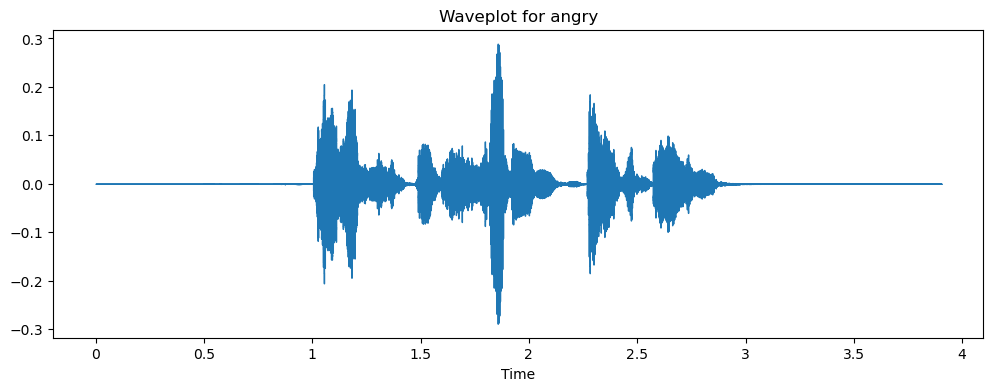

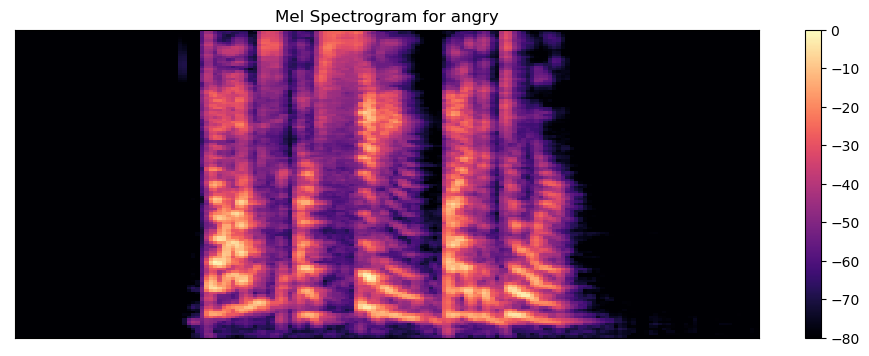

In [23]:
# test cell, delete later
emotion = "angry"
file = emotion_tag_df.loc[emotion_tag_df['emotion'] == emotion]['file_path'].values[0]
data, sample_rate = librosa.load(ravdess_path + file)
generate_wave_plot(data, sample_rate, emotion)
generate_mel_spectrogram(data, sample_rate, emotion)

## Data Augmentation
- Primarily depending on adding noise and altering pitch 

In [24]:
def noise(data):
    '''
    Function that adds noise to the audio data by adding a random number to each data point
    
    input: data
    output: data with noise
    '''
    return data + 0.005 * np.random.normal(loc=0.0, scale=1.0, size=data.shape)

def pitch(data, sample_rate):
    '''
    Function that adds pitch to the audio data by changing the pitch of the audio
    
    input: data, sample_rate
    output: data with pitch
    '''
    return librosa.effects.pitch_shift(data, sample_rate, n_steps=2)

In [25]:
Audio(pitch(data, sample_rate), rate=sample_rate)

/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_1515/2517709884.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sample_rate, n_steps=2)


## Feature Extraction
- We are primarily focused on extracting MFCC and MelSpectrograms

In [39]:
def feature_extraction(data):
    '''
    Function extracts MFCC and MelSpectrograms
    
    input: audio data
    output: nump array
    '''
    
    result = []
    
    # MFCC extraction 
    MFCC = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result.extend(MFCC)
    
    # MelSpectrogram extraction
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result.extend(mel_spectrogram)
    
    return np.asarray(result)

def feature_from_file_path(filepath):
    '''
    Function takes in a file path and extracts features using feature_extraction
    
    input: file path
    output: numpy array
    '''
    # Code to ignore blank space in our audio (first few and last few seconds)
    DURATION = 2.5 # Duration in seconds
    OFFSET = 0.5 # Offset in seconds
    data, sample_rate = librosa.load(ravdess_path + filepath, duration=DURATION, offset=OFFSET)
    
    # first, we account for audio without any augmentations
    result_1 = feature_extraction(data)
    features = np.array(result_1)
    
    # data with noise
    result_noise = feature_extraction(noise(data))
    features = np.vstack((features, result_noise))
    
    # data with pitching
    result_pitch = feature_extraction(pitch(data, sample_rate))
    features = np.vstack((features, result_pitch))
    
    # return numpy array
    return features

In [40]:
label__df = []
labels = []
# 3 features extracted per file, 1440 files logged, expected iterations: 1440*3 = 4320
for emotion, path in tqdm(zip(emotion_tag_df['emotion'], emotion_tag_df['file_path'])):
    # per augmentation
    features = feature_from_file_path(path)
    for ele in features:
        label__df.append(ele)
        labels.append(emotion)

0it [00:00, ?it/s]/var/folders/jf/c8f7b3_x0x9c5j45htwwt28c0000gn/T/ipykernel_1515/2517709884.py:17: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.pitch_shift(data, sample_rate, n_steps=2)
1440it [03:09,  7.60it/s]


In [41]:
len(label__df), len(labels)

(4320, 4320)

In [47]:
new_emotion_df = pd.DataFrame(label__df)
new_emotion_df['feature'] = labels
# to save iterations, extract to new csv
new_emotion_df.to_csv('../dataset/new_emotion_df.csv', index=False)

## Neural Net

In [60]:
X = new_emotion_df.iloc[:, :-1].values
Y = new_emotion_df["feature"].values

# one hot encoding
encoder = OneHotEncoder()

Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [70]:
# splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

## Pytorch Implementation

In [76]:
# building the model
model = torchvision.models.resnet18(pretrained=True)
loss = nn.CrossEntropyLoss()
model.fc = nn.Linear(512, 8)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)



/Users/vaibhav/opt/anaconda3/envs/main/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/vaibhav/opt/anaconda3/envs/main/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
